### This notebook shows an example of using GAN to generate images

Source: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

In [1]:
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint
import tensorflow as tf
from keras.datasets import fashion_mnist
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
from keras.layers import LeakyReLU, Dropout, Embedding
from keras.layers import BatchNormalization, Activation
from keras import initializers
from keras.initializers import RandomNormal
import keras.optimizers 
from matplotlib import pyplot
import numpy as np
from math import sqrt

### Using the [fashion_mnist](https://www.tensorflow.org/datasets/catalog/fashion_mnist) dataset

In [2]:

(X_train, _), (_, _) = fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 127.5 - 1
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

4422102/4422102 [==============================] - 1s 0us/step
(60000, 28, 28, 1)


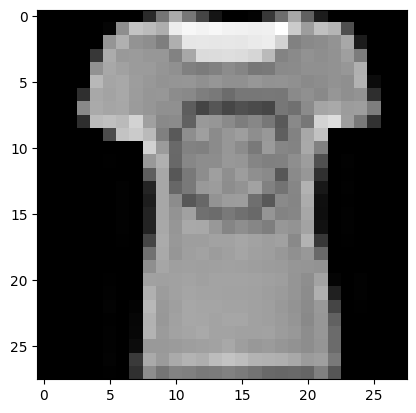

In [3]:
pyplot.imshow(X_train[441], cmap='gray')

In [75]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)  
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

In [76]:
def generate_real_samples(X_train, n_samples):
    ix = randint(0, X_train.shape[0], n_samples) 
    X = X_train[ix]  
    y = ones((n_samples, 1)) 
    return X, y

In [77]:
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict(z_input)  
    y = zeros((n_samples, 1))
    return images, y

In [78]:
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(100):
        pyplot.subplot(10, 10, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    filename2 = 'mnist_model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s' % (filename2))

In [79]:
from math import sqrt

def save_plot(examples, n_examples):
    for i in range(n_examples):
        pyplot.subplot(int(sqrt(n_examples)), int(sqrt(n_examples)), 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

In [80]:
def define_discriminator(in_shape=(28, 28, 1)):
    init = RandomNormal(stddev=0.02)  
    in_image = Input(shape=in_shape)
    fe = Flatten()(in_image)
    fe = Dense(1024)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(512)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(256)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    out = Dense(1, activation='sigmoid')(fe)
    model = Model(in_image, out)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5) 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [81]:
discriminator = define_discriminator()

In [82]:
def define_generator(latent_dim): 
    init = RandomNormal(stddev=0.02)
    in_lat = Input(shape=(latent_dim,)) 
    gen = Dense(256, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(512, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(1024, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(28 * 28 * 1, kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    out_layer = Reshape((28, 28, 1))(gen)
    model = Model(in_lat, out_layer)
    return model

In [83]:
generator = define_generator(100)

In [84]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    gan_output = d_model(g_model.output)
    model = Model(g_model.input, gan_output)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [85]:
gan_model = define_gan(generator, discriminator)

In [86]:
def train(g_model, d_model, gan_model, X_train, latent_dim, n_epochs=10, n_batch=128):
    bat_per_epo = int(X_train.shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs
    print("bat_per_epo", bat_per_epo, n_steps)
    for i in range(n_steps):
        X_real, y_real = generate_real_samples(X_train, n_batch)
        d_loss_r, d_acc_r = d_model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
        d_loss_f, d_acc_f = d_model.train_on_batch(X_fake, y_fake)
        z_input = generate_latent_points(latent_dim, n_batch) 
        y_gan = ones((n_batch, 1)) 
        g_loss, g_acc = gan_model.train_on_batch(z_input, y_gan)
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_loss_r,d_acc_r, d_loss_f,d_acc_f, g_loss,g_acc))
        if (i+1) % (bat_per_epo * 1) == 0:
            print("call summarize_performance ")
            summarize_performance(i, g_model, latent_dim)## This function saves the model for later use, as the training will take up some time
      
    return g_model

bat_per_epo 468 4680
4/4 [==============================] - 0s 3ms/step
>1, dr[0.008,1.000], df[0.689,0.789], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>2, dr[0.007,1.000], df[0.678,0.977], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>3, dr[0.005,1.000], df[0.668,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>4, dr[0.005,1.000], df[0.653,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>5, dr[0.006,1.000], df[0.640,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>6, dr[0.003,1.000], df[0.622,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>7, dr[0.006,1.000], df[0.609,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 2ms/step
>8, dr[0.004,1.000], df[0.586,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>9, dr[0.004,1.000], df[0.562,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3

>Saved: mnist_model_0468.h5
4/4 [==============================] - 0s 3ms/step
>469, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>470, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>471, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>472, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>473, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>474, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>475, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>476, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>477, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [=============

>Saved: mnist_model_0936.h5
4/4 [==============================] - 0s 5ms/step
>937, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>938, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>939, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>940, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>941, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>942, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>943, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>944, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>945, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [=============

>Saved: mnist_model_1404.h5
4/4 [==============================] - 0s 4ms/step
>1405, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>1406, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>1407, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>1408, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>1409, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 6ms/step
>1410, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 5ms/step
>1411, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>1412, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>1413, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [====

>Saved: mnist_model_1872.h5
4/4 [==============================] - 0s 3ms/step
>1873, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>1874, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>1875, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>1876, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>1877, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>1878, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>1879, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>1880, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>1881, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [====

>Saved: mnist_model_2340.h5
4/4 [==============================] - 0s 3ms/step
>2341, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>2342, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>2343, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>2344, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>2345, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>2346, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>2347, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>2348, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>2349, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [====

>Saved: mnist_model_2808.h5
4/4 [==============================] - 0s 6ms/step
>2809, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>2810, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>2811, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>2812, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>2813, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>2814, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>2815, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>2816, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>2817, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [====

>Saved: mnist_model_3276.h5
4/4 [==============================] - 0s 4ms/step
>3277, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>3278, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>3279, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>3280, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>3281, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>3282, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 5ms/step
>3283, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>3284, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 5ms/step
>3285, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [====

>Saved: mnist_model_3744.h5
4/4 [==============================] - 0s 3ms/step
>3745, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>3746, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>3747, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 5ms/step
>3748, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>3749, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>3750, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>3751, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 2ms/step
>3752, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 2ms/step
>3753, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [====

>Saved: mnist_model_4212.h5
4/4 [==============================] - 0s 3ms/step
>4213, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>4214, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>4215, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 5ms/step
>4216, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>4217, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>4218, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>4219, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>4220, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 5ms/step
>4221, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [====

>Saved: mnist_model_4680.h5


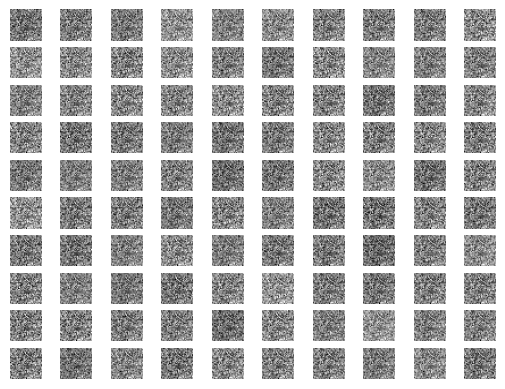

In [44]:
latent_dim = 100
gan = train(generator, discriminator, gan_model, X_train, latent_dim, n_epochs=10, n_batch=128)

1/1 [==============================] - 0s 84ms/step


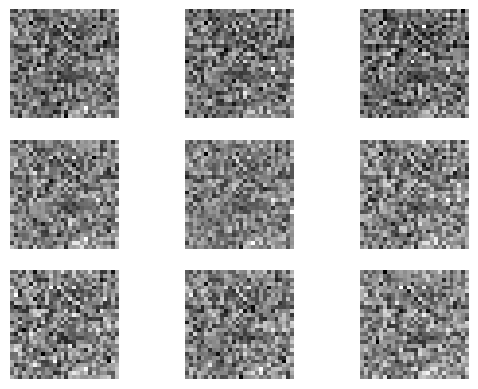

In [54]:
gan = load_model('/content/mnist_model_4680.h5')## Loading the saved model if used later
latent_dim = 100
n_examples = 9
latent_points = generate_latent_points(latent_dim, n_examples)
X  = gan.predict(latent_points)
X = (X + 1) / 2.0
n_examples = round(n_examples)
save_plot(X, n_examples)

## Lab 4
### Use this code to generate handwritten digits using the mnist dataset
#### The mnist dataset is available under keras.datasets

In [74]:
(X_train, _), (_, _) = keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32) / 127.5 - 1
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

(60000, 28, 28, 1)


bat_per_epo 468 4680
4/4 [==============================] - 0s 3ms/step
>1, dr[0.542,0.703], df[0.701,0.016], g[0.688,0.930]
4/4 [==============================] - 0s 3ms/step
>2, dr[0.020,1.000], df[0.712,0.000], g[0.679,1.000]
4/4 [==============================] - 0s 2ms/step
>3, dr[0.005,1.000], df[0.725,0.000], g[0.668,1.000]
4/4 [==============================] - 0s 3ms/step
>4, dr[0.003,1.000], df[0.738,0.000], g[0.658,1.000]
4/4 [==============================] - 0s 3ms/step
>5, dr[0.003,1.000], df[0.754,0.000], g[0.641,1.000]
4/4 [==============================] - 0s 3ms/step
>6, dr[0.003,1.000], df[0.778,0.000], g[0.629,1.000]
4/4 [==============================] - 0s 3ms/step
>7, dr[0.004,1.000], df[0.800,0.000], g[0.616,1.000]
4/4 [==============================] - 0s 4ms/step
>8, dr[0.006,1.000], df[0.818,0.000], g[0.614,1.000]
4/4 [==============================] - 0s 2ms/step
>9, dr[0.006,1.000], df[0.813,0.000], g[0.636,0.953]
4/4 [==============================] - 0s 2

>Saved: mnist_model_0468.h5
4/4 [==============================] - 0s 4ms/step
>469, dr[0.018,1.000], df[0.058,1.000], g[3.736,0.000]
4/4 [==============================] - 0s 4ms/step
>470, dr[0.025,1.000], df[0.057,1.000], g[3.562,0.000]
4/4 [==============================] - 0s 4ms/step
>471, dr[0.034,1.000], df[0.061,1.000], g[3.494,0.000]
4/4 [==============================] - 0s 5ms/step
>472, dr[0.023,0.992], df[0.064,1.000], g[3.602,0.000]
4/4 [==============================] - 0s 4ms/step
>473, dr[0.028,0.992], df[0.065,1.000], g[3.673,0.000]
4/4 [==============================] - 0s 3ms/step
>474, dr[0.046,0.992], df[0.071,1.000], g[3.582,0.000]
4/4 [==============================] - 0s 3ms/step
>475, dr[0.058,0.984], df[0.117,1.000], g[3.915,0.000]
4/4 [==============================] - 0s 3ms/step
>476, dr[0.117,0.953], df[0.179,0.984], g[4.154,0.000]
4/4 [==============================] - 0s 5ms/step
>477, dr[0.111,0.961], df[0.071,1.000], g[3.995,0.000]
4/4 [=============

>Saved: mnist_model_0936.h5
4/4 [==============================] - 0s 3ms/step
>937, dr[0.123,0.953], df[0.207,0.945], g[4.545,0.000]
4/4 [==============================] - 0s 3ms/step
>938, dr[0.223,0.906], df[0.319,0.898], g[5.021,0.000]
4/4 [==============================] - 0s 3ms/step
>939, dr[0.234,0.883], df[0.277,0.914], g[5.127,0.000]
4/4 [==============================] - 0s 3ms/step
>940, dr[0.264,0.859], df[0.422,0.844], g[5.583,0.000]
4/4 [==============================] - 0s 3ms/step
>941, dr[0.715,0.703], df[0.685,0.672], g[4.433,0.016]
4/4 [==============================] - 0s 3ms/step
>942, dr[0.220,0.891], df[0.106,0.984], g[4.416,0.008]
4/4 [==============================] - 0s 3ms/step
>943, dr[0.245,0.883], df[0.245,0.914], g[3.743,0.008]
4/4 [==============================] - 0s 3ms/step
>944, dr[0.128,0.953], df[0.244,0.938], g[4.532,0.000]
4/4 [==============================] - 0s 3ms/step
>945, dr[0.251,0.930], df[0.227,0.938], g[4.159,0.000]
4/4 [=============

>Saved: mnist_model_1404.h5
4/4 [==============================] - 0s 3ms/step
>1405, dr[0.428,0.773], df[0.572,0.773], g[3.263,0.000]
4/4 [==============================] - 0s 5ms/step
>1406, dr[0.469,0.773], df[0.358,0.875], g[2.955,0.008]
4/4 [==============================] - 0s 3ms/step
>1407, dr[0.320,0.812], df[0.338,0.898], g[3.345,0.000]
4/4 [==============================] - 0s 4ms/step
>1408, dr[0.390,0.852], df[0.315,0.898], g[3.065,0.000]
4/4 [==============================] - 0s 3ms/step
>1409, dr[0.399,0.773], df[0.424,0.820], g[3.249,0.008]
4/4 [==============================] - 0s 3ms/step
>1410, dr[0.388,0.812], df[0.284,0.922], g[2.965,0.008]
4/4 [==============================] - 0s 3ms/step
>1411, dr[0.387,0.797], df[0.419,0.852], g[3.104,0.008]
4/4 [==============================] - 0s 4ms/step
>1412, dr[0.307,0.852], df[0.180,0.953], g[3.079,0.000]
4/4 [==============================] - 0s 3ms/step
>1413, dr[0.323,0.820], df[0.349,0.906], g[2.930,0.023]
4/4 [====

>Saved: mnist_model_1872.h5
4/4 [==============================] - 0s 5ms/step
>1873, dr[0.390,0.797], df[0.519,0.797], g[3.745,0.016]
4/4 [==============================] - 0s 3ms/step
>1874, dr[0.526,0.742], df[0.218,0.945], g[3.181,0.016]
4/4 [==============================] - 0s 4ms/step
>1875, dr[0.358,0.812], df[0.504,0.820], g[3.067,0.008]
4/4 [==============================] - 0s 4ms/step
>1876, dr[0.356,0.797], df[0.306,0.891], g[2.927,0.000]
4/4 [==============================] - 0s 4ms/step
>1877, dr[0.451,0.828], df[0.289,0.898], g[2.822,0.008]
4/4 [==============================] - 0s 4ms/step
>1878, dr[0.341,0.828], df[0.304,0.914], g[2.915,0.008]
4/4 [==============================] - 0s 4ms/step
>1879, dr[0.446,0.789], df[0.652,0.781], g[3.328,0.000]
4/4 [==============================] - 0s 4ms/step
>1880, dr[0.513,0.758], df[0.183,0.969], g[2.945,0.000]
4/4 [==============================] - 0s 4ms/step
>1881, dr[0.326,0.820], df[0.357,0.875], g[2.642,0.023]
4/4 [====

>Saved: mnist_model_2340.h5
4/4 [==============================] - 0s 2ms/step
>2341, dr[0.437,0.781], df[0.366,0.859], g[2.851,0.000]
4/4 [==============================] - 0s 4ms/step
>2342, dr[0.295,0.859], df[0.291,0.906], g[2.848,0.008]
4/4 [==============================] - 0s 3ms/step
>2343, dr[0.363,0.828], df[0.424,0.828], g[2.883,0.000]
4/4 [==============================] - 0s 4ms/step
>2344, dr[0.350,0.836], df[0.305,0.922], g[2.988,0.000]
4/4 [==============================] - 0s 3ms/step
>2345, dr[0.394,0.812], df[0.458,0.797], g[3.226,0.016]
4/4 [==============================] - 0s 3ms/step
>2346, dr[0.606,0.688], df[0.400,0.828], g[2.814,0.008]
4/4 [==============================] - 0s 4ms/step
>2347, dr[0.530,0.734], df[0.656,0.734], g[3.258,0.000]
4/4 [==============================] - 0s 4ms/step
>2348, dr[0.682,0.664], df[0.242,0.930], g[2.370,0.008]
4/4 [==============================] - 0s 3ms/step
>2349, dr[0.363,0.836], df[0.553,0.703], g[2.636,0.016]
4/4 [====

>Saved: mnist_model_2808.h5
4/4 [==============================] - 0s 4ms/step
>2809, dr[0.398,0.797], df[0.361,0.867], g[2.453,0.023]
4/4 [==============================] - 0s 2ms/step
>2810, dr[0.336,0.867], df[0.430,0.852], g[2.718,0.023]
4/4 [==============================] - 0s 3ms/step
>2811, dr[0.464,0.773], df[0.364,0.883], g[2.511,0.039]
4/4 [==============================] - 0s 4ms/step
>2812, dr[0.492,0.742], df[0.485,0.812], g[2.353,0.039]
4/4 [==============================] - 0s 3ms/step
>2813, dr[0.335,0.836], df[0.340,0.898], g[2.535,0.016]
4/4 [==============================] - 0s 3ms/step
>2814, dr[0.418,0.758], df[0.468,0.828], g[2.550,0.008]
4/4 [==============================] - 0s 4ms/step
>2815, dr[0.337,0.820], df[0.378,0.867], g[2.519,0.008]
4/4 [==============================] - 0s 2ms/step
>2816, dr[0.505,0.719], df[0.359,0.875], g[2.524,0.023]
4/4 [==============================] - 0s 3ms/step
>2817, dr[0.362,0.820], df[0.444,0.836], g[2.805,0.031]
4/4 [====

>Saved: mnist_model_3276.h5
4/4 [==============================] - 0s 5ms/step
>3277, dr[0.232,0.898], df[0.293,0.914], g[3.217,0.008]
4/4 [==============================] - 0s 3ms/step
>3278, dr[0.377,0.797], df[0.304,0.875], g[3.228,0.000]
4/4 [==============================] - 0s 4ms/step
>3279, dr[0.427,0.766], df[0.283,0.922], g[2.782,0.016]
4/4 [==============================] - 0s 7ms/step
>3280, dr[0.284,0.867], df[0.327,0.867], g[2.815,0.016]
4/4 [==============================] - 0s 4ms/step
>3281, dr[0.325,0.820], df[0.294,0.906], g[3.020,0.016]
4/4 [==============================] - 0s 4ms/step
>3282, dr[0.462,0.758], df[0.383,0.844], g[2.865,0.016]
4/4 [==============================] - 0s 3ms/step
>3283, dr[0.334,0.859], df[0.307,0.891], g[2.885,0.047]
4/4 [==============================] - 0s 4ms/step
>3284, dr[0.309,0.812], df[0.408,0.844], g[3.077,0.016]
4/4 [==============================] - 0s 4ms/step
>3285, dr[0.545,0.766], df[0.263,0.891], g[2.796,0.039]
4/4 [====

>Saved: mnist_model_3744.h5
4/4 [==============================] - 0s 4ms/step
>3745, dr[0.284,0.875], df[0.517,0.789], g[2.906,0.008]
4/4 [==============================] - 0s 4ms/step
>3746, dr[0.485,0.734], df[0.388,0.867], g[2.629,0.039]
4/4 [==============================] - 0s 4ms/step
>3747, dr[0.323,0.859], df[0.330,0.898], g[2.801,0.016]
4/4 [==============================] - 0s 4ms/step
>3748, dr[0.538,0.719], df[0.344,0.891], g[2.411,0.039]
4/4 [==============================] - 0s 4ms/step
>3749, dr[0.408,0.797], df[0.434,0.852], g[2.596,0.023]
4/4 [==============================] - 0s 3ms/step
>3750, dr[0.414,0.836], df[0.439,0.812], g[2.642,0.031]
4/4 [==============================] - 0s 4ms/step
>3751, dr[0.405,0.797], df[0.361,0.844], g[2.553,0.039]
4/4 [==============================] - 0s 5ms/step
>3752, dr[0.413,0.820], df[0.319,0.898], g[2.433,0.031]
4/4 [==============================] - 0s 5ms/step
>3753, dr[0.347,0.836], df[0.376,0.859], g[2.737,0.016]
4/4 [====

>Saved: mnist_model_4212.h5
4/4 [==============================] - 0s 5ms/step
>4213, dr[0.529,0.719], df[0.330,0.906], g[2.017,0.070]
4/4 [==============================] - 0s 4ms/step
>4214, dr[0.336,0.852], df[0.336,0.898], g[2.071,0.039]
4/4 [==============================] - 0s 5ms/step
>4215, dr[0.307,0.852], df[0.470,0.844], g[2.207,0.039]
4/4 [==============================] - 0s 4ms/step
>4216, dr[0.464,0.773], df[0.387,0.906], g[2.313,0.023]
4/4 [==============================] - 0s 2ms/step
>4217, dr[0.340,0.789], df[0.273,0.914], g[2.300,0.008]
4/4 [==============================] - 0s 5ms/step
>4218, dr[0.428,0.812], df[0.422,0.867], g[2.107,0.062]
4/4 [==============================] - 0s 5ms/step
>4219, dr[0.489,0.711], df[0.402,0.852], g[2.218,0.062]
4/4 [==============================] - 0s 4ms/step
>4220, dr[0.346,0.844], df[0.333,0.914], g[2.377,0.031]
4/4 [==============================] - 0s 3ms/step
>4221, dr[0.402,0.773], df[0.385,0.891], g[2.370,0.047]
4/4 [====

>Saved: mnist_model_4680.h5


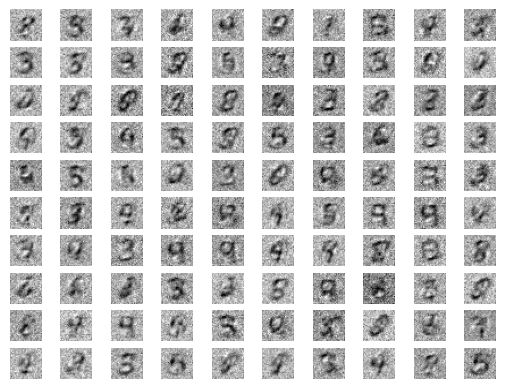

In [87]:
latent_dim = 100
gan = train(generator, discriminator, gan_model, X_train, latent_dim, n_epochs=10, n_batch=128)

2/2 [==============================] - 0s 5ms/step


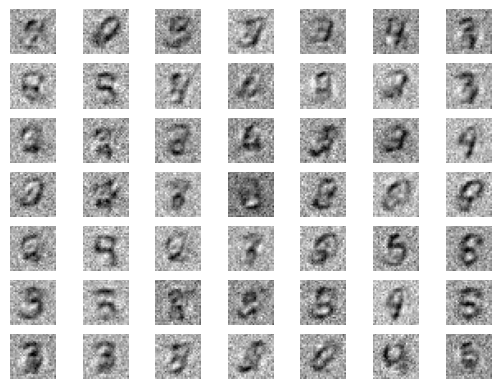

In [90]:
gan = load_model('/content/mnist_model_4680.h5')## Loading the saved model if used later
latent_dim = 100
n_examples = 49
latent_points = generate_latent_points(latent_dim, n_examples)
X  = gan.predict(latent_points)
X = (X + 1) / 2.0
n_examples = round(n_examples)
save_plot(X, n_examples)